### Contents

Import Data

Subset/Wrangle Data

Decomposition

Testing for Stationarity

Stationarizing the Data

### Import Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
quandl.ApiConfig.api_key = 'XuFrbqRYz5z864cRFjVH'

In [3]:
# import data on wheat prices
data = quandl.get('FRED/WPU0121')

In [4]:
data.head()

,Value
Date,
1947-01-01,53.1
1947-02-01,56.5
1947-03-01,68.0
1947-04-01,66.0
1947-05-01,66.7


In [5]:
data.shape

(901, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

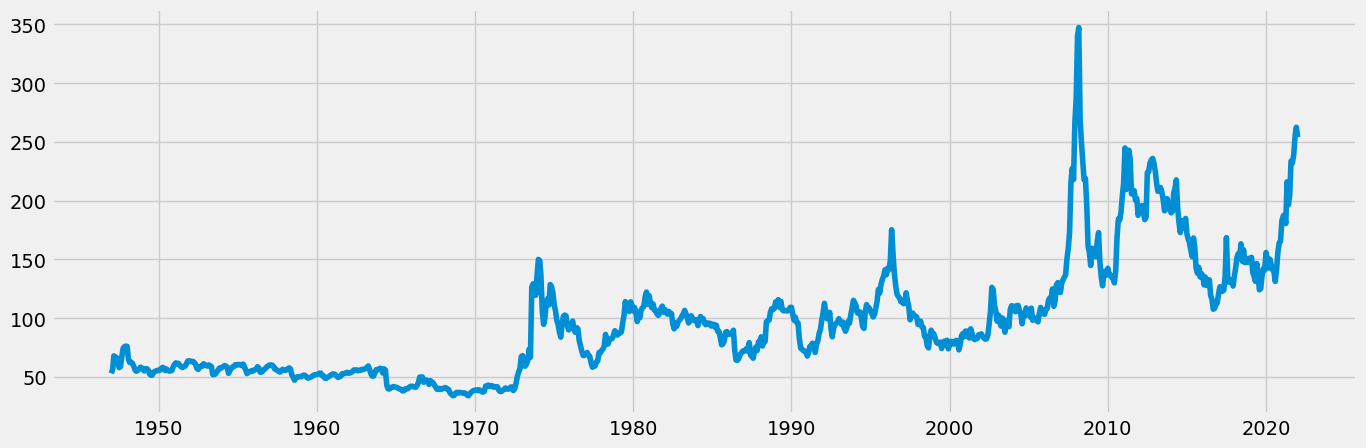

In [7]:
# plot data using matplotlib
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

### Subset/Wrangle Data

In [8]:
# Reset index so that you can use the "Date" column as a filter
data_2 = data.reset_index()

In [9]:
data_sub = data_2.loc[(data_2['Date'] >= '2005-01-01')]

I chose to include data after 2005 as I wanted there to be enough data to see any trends that might be happening for the cost of wheat. While the cost of wheat in 2005 isn't strictly relevent, it will help create trend lines and see if anything sticks out about pricing.

In [10]:
data_sub.head()

,Date,Value
696,2005-01-01,105.7
697,2005-02-01,101.2
698,2005-03-01,108.6
699,2005-04-01,98.3
700,2005-05-01,100.3


In [11]:
# missing values
data_sub.isnull().sum() 

Date     0
Value    0
dtype: int64

In [12]:
# duplicates
dups = data_sub.duplicated()
dups.sum()

0

In [13]:
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime')
data_sub.drop(['Date'], axis=1, inplace=True)
data_sub.head()

,Value
datetime,
2005-01-01,105.7
2005-02-01,101.2
2005-03-01,108.6
2005-04-01,98.3
2005-05-01,100.3


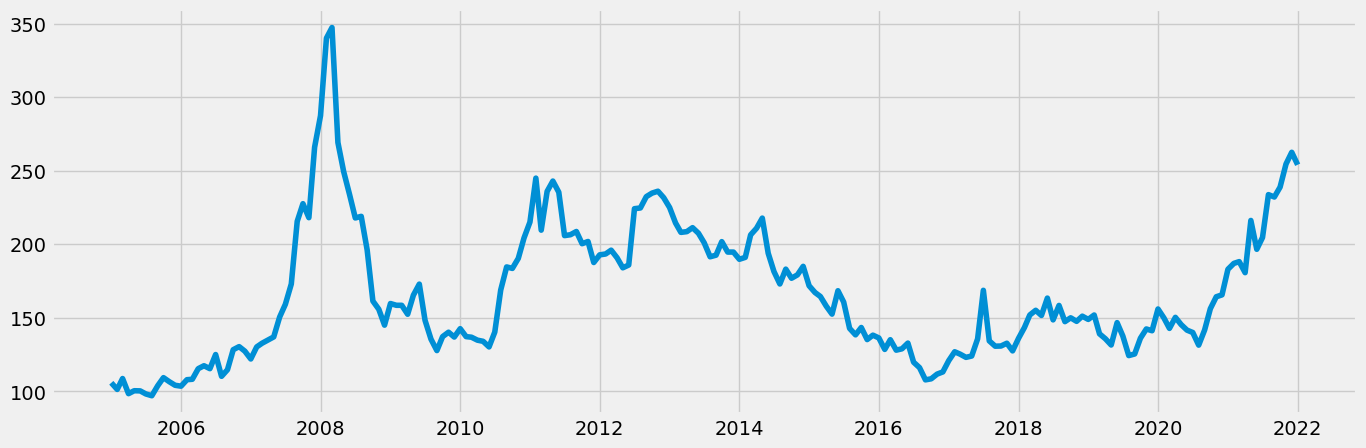

In [14]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

### Decomposition

In [15]:
# decompose using a multiplicative model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='multiplicative')

In [16]:
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

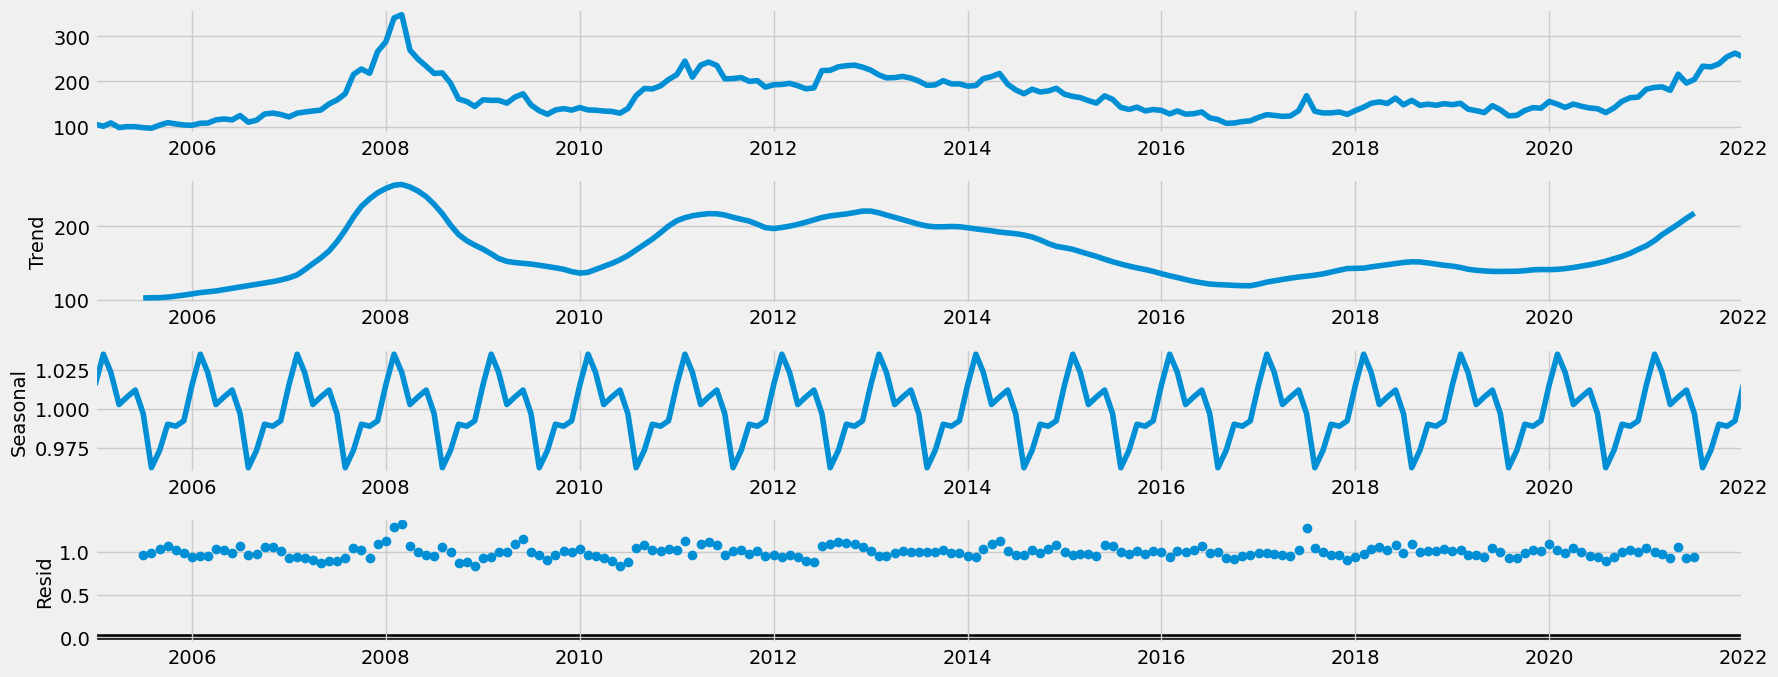

In [17]:
decomposition.plot()
plt.show()

From these charts I can see that there is currently (as of 2022) an upward trend in the price of wheat, approaching the peak of 2008. Additionally, wheat prices seem to peak in the early months of a year before dropping towards the middle of the year and climbing back up. This correlates with the harvest time of wheat and when the new wheat crops go on sale. Although I didn't smooth the data there is very little risidual noise left over, indicating that there isn't much noise at all and wheat prices tend to closely follow the trend line.

### Testing for Stationarity

In [18]:
# perform Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.277724
p-value                          0.179253
Number of Lags Used              1.000000
Number of Observations Used    203.000000
Critical Value (1%)             -3.462980
Critical Value (5%)             -2.875885
Critical Value (10%)            -2.574416
dtype: float64


The Critical Value (5%) is slightly lower than the Test Statistic. This means that I can't rule out my data having a unit root and it is likely that the data is non-stationary, which I assumed from looking at the charts. 

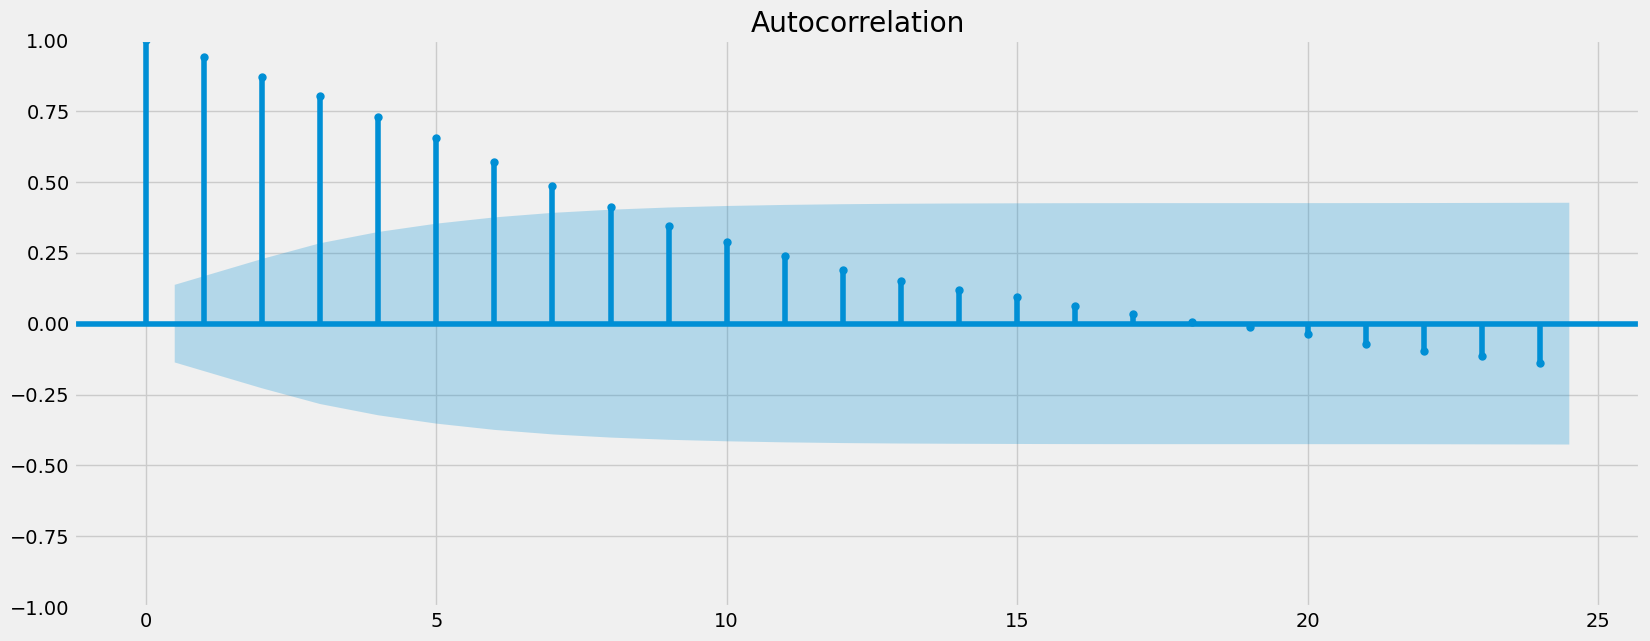

In [19]:
# plot autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

This shows that there is a decent amount of autocorrelation occurring in the data, proving again that the data is non-stationary. 

### Stationarizing the Data

In [20]:
# stationize the data through differencing
data_diff = data_sub - data_sub.shift(1)

In [21]:
data_diff.dropna(inplace = True)

In [22]:
data_diff.head()

,Value
datetime,
2005-02-01,-4.5
2005-03-01,7.4
2005-04-01,-10.3
2005-05-01,2.0
2005-06-01,-0.1


In [23]:
data_diff.columns

Index(['Value'], dtype='object')

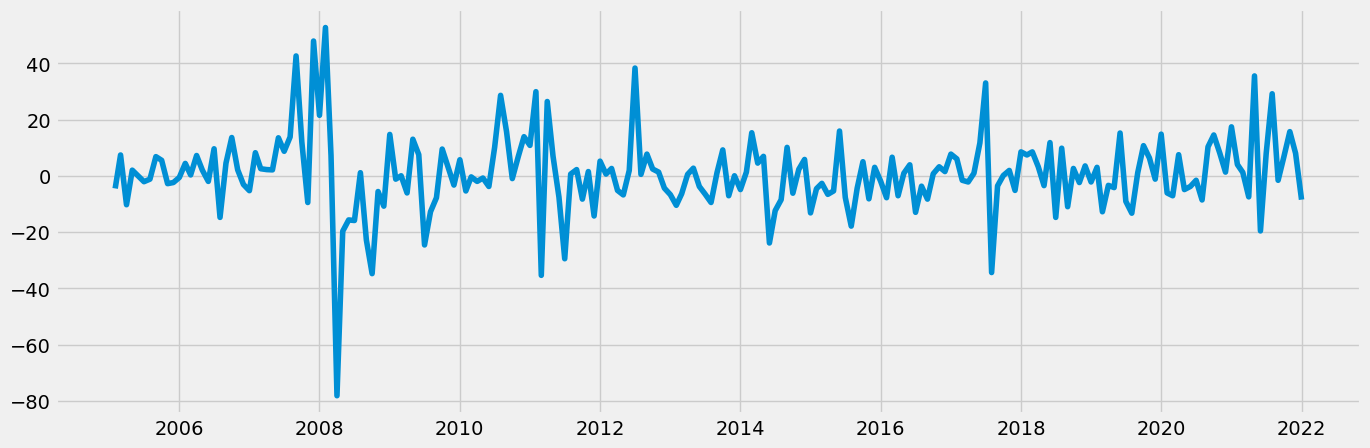

In [24]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [25]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.284133e+01
p-value                        5.598847e-24
Number of Lags Used            0.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -3.462980e+00
Critical Value (5%)           -2.875885e+00
Critical Value (10%)          -2.574416e+00
dtype: float64


In [26]:
data_diff2 = data_diff - data_diff.shift(1)

In [27]:
data_diff2.dropna(inplace = True)

In [28]:
data_diff2.head()

,Value
datetime,
2005-03-01,11.9
2005-04-01,-17.7
2005-05-01,12.3
2005-06-01,-2.1
2005-07-01,-2.0


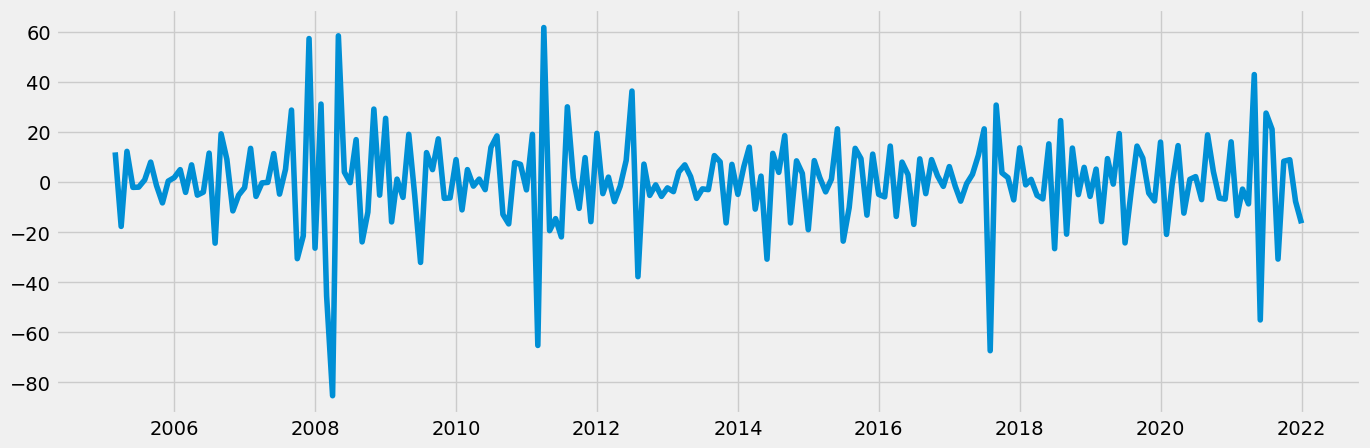

In [29]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [30]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -6.872474e+00
p-value                        1.503365e-09
Number of Lags Used            1.300000e+01
Number of Observations Used    1.890000e+02
Critical Value (1%)           -3.465431e+00
Critical Value (5%)           -2.876957e+00
Critical Value (10%)          -2.574988e+00
dtype: float64


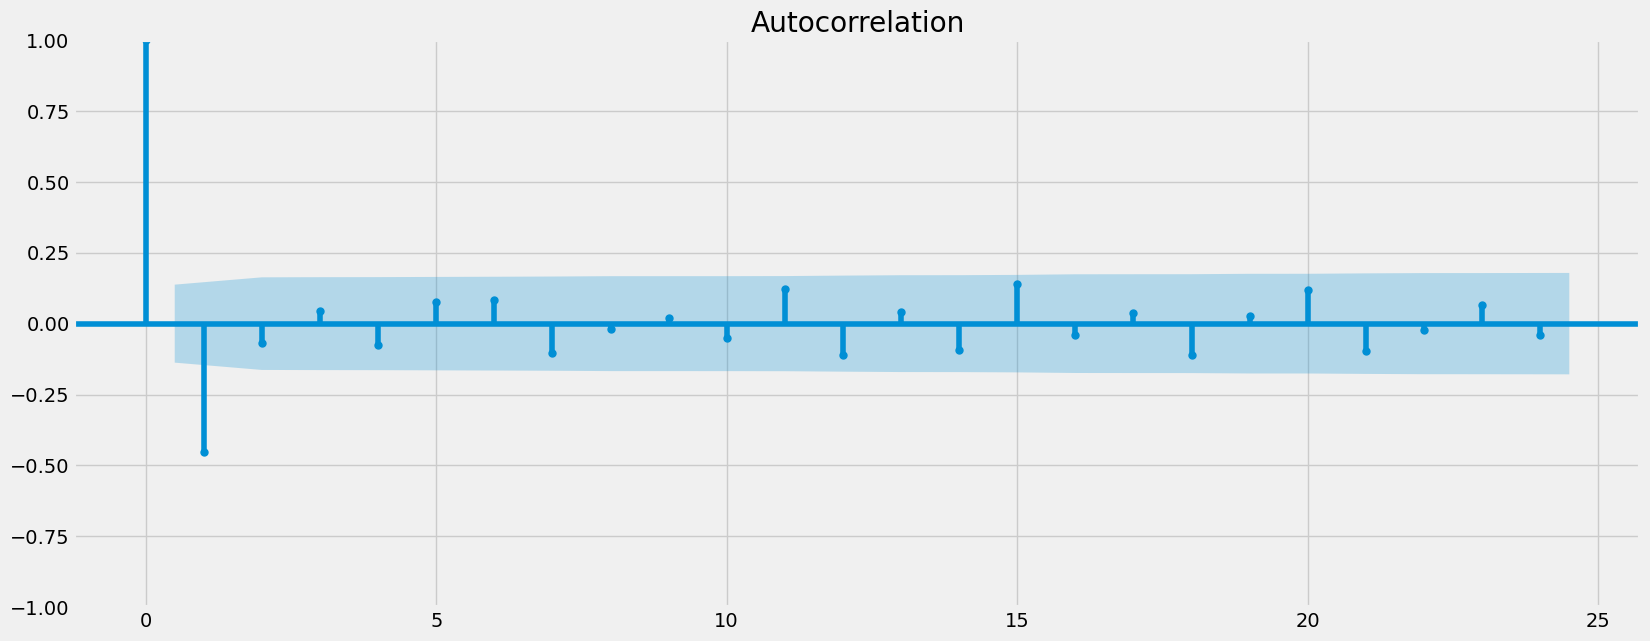

In [31]:
# plot autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_diff2)
plt.show()